# Analysis of RNN performance accuracy comparing P, BNP

1. compare R^2 (aggregated preds/labs vs. paired t test)
2. compare accuracies (paired t test)
3. heat map

In [189]:
import itertools
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import pickle
import random
from sklearn.model_selection import train_test_split
import time
from joblib import Parallel, delayed
import pandas as pd
import sys
import os
import seaborn as sns 
from sklearn.metrics import r2_score
import math
import matplotlib as mpl
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances
import scipy
from matplotlib import cm
from matplotlib.lines import Line2D
from sklearn.decomposition import PCA
import statannot
from cryptic_rnn import *


In [190]:
#save_dir = '../results/corrected/addition_trigrams_3inputs_bp_800'
save_dir = '../results/train_2seqs/res_20'
with open(save_dir, 'rb') as f:
    res = pickle.load(f)

# R^2 scores

1. plot prediction against ground truth for all models for the 4 conditions
2. compare individual model r^2 values

In [191]:
############### Functions: R squared comparison ###############

def get_r2_and_preds(mods, tests, hidden_size=20):
    dfs = []
    r2s = []
    for i in range(len(mods)):
        df = test_preds(mods[i], [tests[i]], hidden_size)
        dfs.append(df) # append data frame of labels and predictions
        r2s.append(r2_score(df['pred'], df['label'])) # individual model r2 score
    all_dfs = pd.concat(dfs)
    all_r2s = r2_score(all_dfs['pred'],all_dfs['label'])
    
    return {'ind_dfs': dfs, 'all_dfs': all_dfs, 'ind_r2s': r2s, 'all_r2s': all_r2s}
    
##################################
### Plotting
##################################
 
bp_pal = {'Balanced': '#00A7E1', 'Primitives':'#F17720'}
bp_colors = ['#00A7E1', '#F17720']

## plotting
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [192]:
hidden_size=20

# extract results
tests = res['tests']
cue_dicts = res['cue_dicts']

mods_b = res['mods_b']
mods_p = res['mods_p']

r2res_p = get_r2_and_preds(mods_p, tests, hidden_size)
r2res_b = get_r2_and_preds(mods_b, tests, hidden_size)

In [193]:
# statistical test:
print('primitives vs balanced', scipy.stats.wilcoxon(r2res_b['ind_r2s'], r2res_p['ind_r2s']))

primitives vs balanced WilcoxonResult(statistic=0.0, pvalue=1.6226417655688113e-112)


### Plot predictions against r2

Text(0.5, 0.94, 'RNN predictions against ground truth')

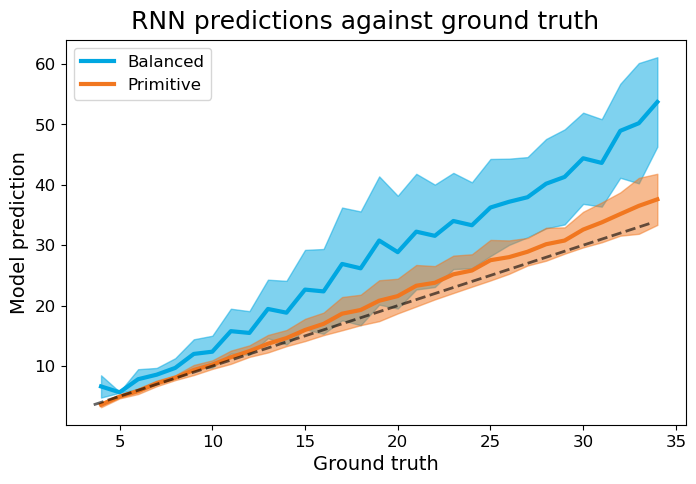

In [230]:
# aggregate all predictions vs labels across models
all_dfs_b = pd.concat(r2res_b['ind_dfs'])
all_dfs_p = pd.concat(r2res_p['ind_dfs'])

labels = ['Balanced', 'Primitive']
plt.rcParams['figure.figsize'] = (8,5)

for i, all_dfs in enumerate([all_dfs_b, all_dfs_p]):
    
    agg_df = all_dfs.groupby(['label']).agg({'pred': ['mean', 'std']})
    yvals = agg_df['pred']['mean']
    yerr = agg_df['pred']['std']
    xvals = agg_df.index
    plt.plot(xvals,yvals, color = bp_colors[i], linewidth=3,label=labels[i])
    plt.fill_between(xvals, yvals - yerr, yvals+yerr, color = bp_colors[i], alpha=0.5)
    xy = np.arange(np.min(yvals),np.max(xvals))
    
plt.plot(xy, xy, color='black', linestyle='dashed',linewidth=2, alpha=0.6)
plt.xlabel('Ground truth')
plt.ylabel('Model prediction')
plt.legend(loc = 'upper left')
plt.suptitle('RNN predictions against ground truth', y=0.94)

### Difference in ind r2 scores

In [206]:
r2_b = r2res_b['ind_r2s']
r2_p = r2res_p['ind_r2s']
N = len(r2_b)

r2_scores = r2_b + r2_p
regimes = ['Balanced']*N + ['Primitive']*N
r2_df = {'R squared score': r2_scores, 'Regime': regimes}

x_jitter = np.zeros(N) + np.random.normal(0, 0.04, N)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  wilcox
Balanced v.s. Primitive: Wilcoxon test (paired samples) with Bonferroni correction, P_val=1.623e-112 stat=0.000e+00


(<AxesSubplot: xlabel='Curriculum', ylabel='$R^2$'>,
 [<statannot.StatResult.StatResult at 0x7fb6224c4190>])

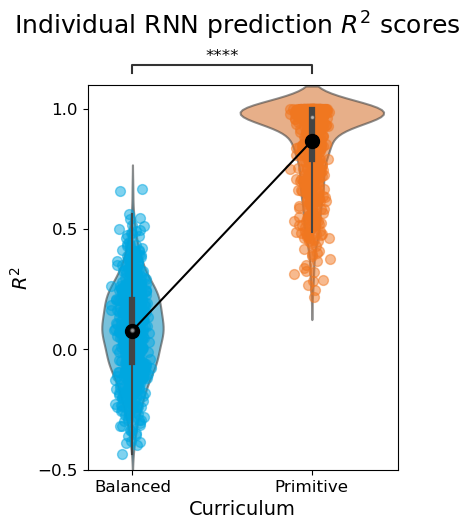

In [234]:
#sns.violinplot(r2_df, x='Regime', y='R squared score', capsize=0.05,errwidth=0.5, palette=bp_pal)

fig, ax = plt.subplots(figsize=(4,5))
sns.violinplot(data=r2_df,x='Regime',y='R squared score', palette=bp_colors)
plt.setp(ax.collections, alpha=.6)

ax.scatter(x_jitter, r2_b, color = bp_colors[0], s=50,  alpha=0.5)
ax.scatter(x_jitter+1, r2_p, color = bp_colors[1], s=50,  alpha=0.5)
ax.plot([0,1], [np.mean(r2_b), np.mean(r2_p)], marker='o', color='black', markersize=10)
ax.set_xticks([0,1])
ax.set_xticklabels(['Balanced','Primitive'])
ax.set_xlabel('Curriculum')
ax.set_ylim(-0.5, 1.1)
ax.set_yticks([ -0.5, 0, 0.5, 1])
ax.set_ylabel('$R^2$')
plt.suptitle('Individual RNN prediction $R^2$ scores', y=1.03)

statannot.add_stat_annotation(
    ax,
    data=r2_df,
    x='Regime',
    y='R squared score',
    box_pairs=[('Balanced', 'Primitive')],
    test="Wilcoxon",
    text_format="star",
    loc="outside",
)


# MSE analysis

In [216]:
def test_modloss(model, testdata, criterion, hidden_size=20):
    model.eval()
    losses_testset = []
    
    for t in testdata:
        loss_set = 0
        for x,y in t:
            for i in range(len(x)):
                hidden = torch.zeros(1, hidden_size)[0]
                for step in x[i]:
                    hidden, y_hat = model.get_activations(step,hidden)
                loss_set += criterion(y_hat, torch.tensor([y[i].item()])).item()
     
        losses_testset.append(loss_set)
        
    return losses_testset


def extract_MSELoss(res1):
    tests = res1['tests']
    mods_b = res1['mods_b']
    mods_p = res1['mods_p']
    criterion = nn.MSELoss()
    mse_b = []
    mse_p = []
    for i in range(len(mods_b)):
        mse_b.append(test_modloss(mods_b[i], [tests[i]], criterion, hidden_size)[0]) 
        mse_p.append(test_modloss(mods_p[i], [tests[i]], criterion, hidden_size)[0]) 
        
    return {'mse_b': mse_b, 'mse_p': mse_p}

criterion = nn.MSELoss()

def ind_losses(mods, test_seqs, hidden_size=20, num_classes=22):
    losses = []
    for i, mod in enumerate(mods):
        cuedict = cue_dicts[i]
        testseqs = change_dict(test_seqs, cuedict)
        test_inputs = convert_seq2inputs(testseqs, num_classes=num_classes, seq_len=5)
        testset = DataLoader(test_inputs, batch_size=batchsize, shuffle=True)
        losses.append(test_loss(mod, [testset], criterion)[0])
    return losses


In [217]:
lossres = extract_MSELoss(res)
lossesb = np.sqrt(lossres['mse_b'])
lossesp = np.sqrt(lossres['mse_p'])
curricula = ['Balanced']*len(lossesb) + ['Primitives']*len(lossesp)
rmse = np.append(lossesb, lossesp)

rmse_df = pd.DataFrame({'Curriculum':curricula, 'RMSE':rmse})

N = len(lossesb)
x_jitter = np.repeat([0], N) + np.random.normal(0, 0.04, N)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  wilcox
Balanced v.s. Primitives: Wilcoxon test (paired samples) with Bonferroni correction, P_val=1.623e-112 stat=0.000e+00


(<AxesSubplot: xlabel='Curriculum', ylabel='RMSE'>,
 [<statannot.StatResult.StatResult at 0x7fb62246d850>])

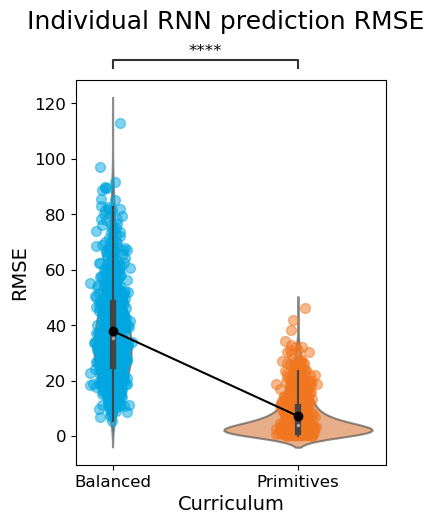

In [235]:
fig, ax = plt.subplots()

plt.rcParams['figure.figsize'] = (4,5)
sns.violinplot(data=rmse_df, x='Curriculum', y='RMSE', capsize=0.1, palette=bp_pal, errwidth=1)
plt.setp(ax.collections, alpha=.6)
y_p = [np.mean(lossesb), np.mean(lossesp)]
ax.plot([0,1], y_p, color = 'black', marker = 'o')
plt.scatter(x_jitter, lossesb, alpha = 0.5, color = bp_colors[0], s= 50)
plt.scatter(x_jitter+1, lossesp, alpha = 0.5, color = bp_colors[1], s=50)
plt.suptitle('Individual RNN prediction RMSE', y=1.02)

statannot.add_stat_annotation(
    ax,
    data=rmse_df,
    x='Curriculum',
    y='RMSE',
    box_pairs=[('Balanced', 'Primitives')],
    test="Wilcoxon",
    text_format="star",
    loc="outside",
)

# Heatmap

Text(0.5, 1.05, 'Mean prediction accuracy for each sequence')

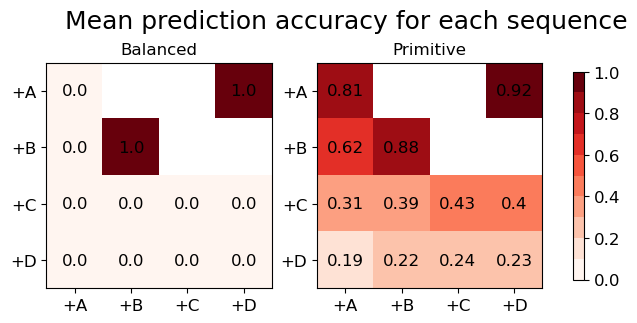

In [236]:
reslist = [r2res_b, r2res_p]

new_reds = cm.get_cmap('Reds', 10)
cmap=new_reds

subtitles = ['Balanced', 'Primitive']
fig, ax = plt.subplots(1,2, figsize=(8,3))
ax = ax.flatten()
for i, r2_res in enumerate(reslist):
    df = r2_res['all_dfs'].groupby('trial').mean()
    heatmap_acc_sign(4, df, ax[i], '+')
    ax[i].title.set_text(subtitles[i])
fig.colorbar(cm.ScalarMappable(cmap=cmap), ax=ax, shrink=0.9)
plt.suptitle('Mean prediction accuracy for each sequence', y=1.05)

In [178]:
save_dir = '../results/fraction_inputs/4_inputs'
with open(save_dir, 'rb') as f:
    mres = pickle.load(f)

In [187]:
res = mres[6]

hidden_size=20

# extract results
tests = res['tests']
cue_dicts = res['cue_dicts']

mods_b = res['mods_b']
mods_p = res['mods_p']

r2res_p = get_r2_and_preds(mods_p, tests, hidden_size)
r2res_b = get_r2_and_preds(mods_b, tests, hidden_size)

Text(0.5, 0.95, 'Prediction accuracy')

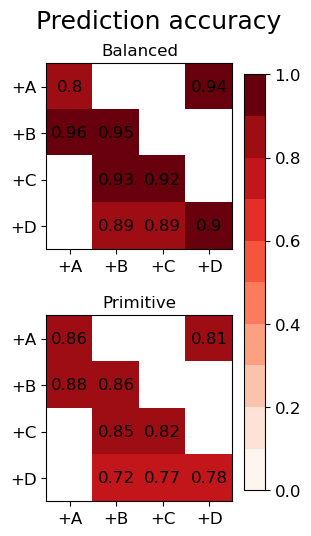

In [188]:
reslist = [r2res_b, r2res_p]

new_reds = cm.get_cmap('Reds', 10)
cmap=new_reds

subtitles = ['Balanced', 'Primitive']
fig, ax = plt.subplots(2,1, figsize=(3,6))
ax = ax.flatten()
for i, r2_res in enumerate(reslist):
    df = r2_res['all_dfs'].groupby('trial').mean()
    heatmap_acc_sign(4, df, ax[i], '+')
    ax[i].title.set_text(subtitles[i])
fig.colorbar(cm.ScalarMappable(cmap=cmap), ax=ax, shrink=0.9)
plt.suptitle('Prediction accuracy', y=0.95)

In [82]:
ff = r2res_b['all_dfs'].groupby('trial').agg(['mean', 'sem'])['acc']
#ff['acc_']
#agg(['min', 'sem'])

In [223]:
def heatmap_acc_sign(num_inputs, df, ax, op):
    
    total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
    map_syms = total_syms[:num_inputs]
    data_accs = np.empty((num_inputs, num_inputs))
    data_accs[:] = np.NaN
    for r, trial in enumerate(df.index):
        i = map_syms.index(eval(trial)[1])
        j = map_syms.index(eval(trial)[3])
        acc = round(df.iloc[r]['acc'], 2)
        data_accs[i,j] = acc
        
    # Loop over data dimensions and create text annotations.
    for i in range(num_inputs):
        for j in range(num_inputs):
            if np.isnan(data_accs[i, j]):
                pass
            else:
                text = ax.text(j,i, data_accs[i, j],
                              ha="center", va="center", color="black", fontsize=12)

    
    # Show all ticks and label them with the respective list entries
    new_reds = cm.get_cmap('Reds', 10)
    cmap=new_reds
    bounds = list(np.arange(0,1.1,0.1))
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    im = ax.imshow(data_accs, cmap=cmap, norm=norm)

    ax_lab = [op+str(ss) for ss in total_syms[:num_inputs]]
    ax.set_xticks(np.arange(num_inputs), labels=ax_lab)
    ax.set_yticks(np.arange(num_inputs), labels=ax_lab)


# Complex addition

In [54]:
test2step = random.sample(generate_pos_trials('+', all_syms, all_syms, cue_dict, steps = 2), 10)

NameError: name 'all_syms' is not defined

In [101]:
cue_dicts = res['cue_dicts']
tests = random.sample(generate_pos_trials(ops, all_syms, all_syms, cue_dict, steps = 2), 10)
test_all = [change_dict(tests, cuedict) for cuedict in cue_dicts]
testsets = []
for t in test_all:
    test_inputs = convert_seq2inputs(t, num_classes=num_classes, seq_len=5)
    testsets.append(DataLoader(test_inputs, batch_size=batchsize, shuffle=True))

r2res_p2 = get_r2_and_preds(mods_p, testsets)
r2res_b2 = get_r2_and_preds(mods_b, testsets)


Text(0.5, 1, 'Aggregate RNN predictions against ground \ntruth for complex addition')

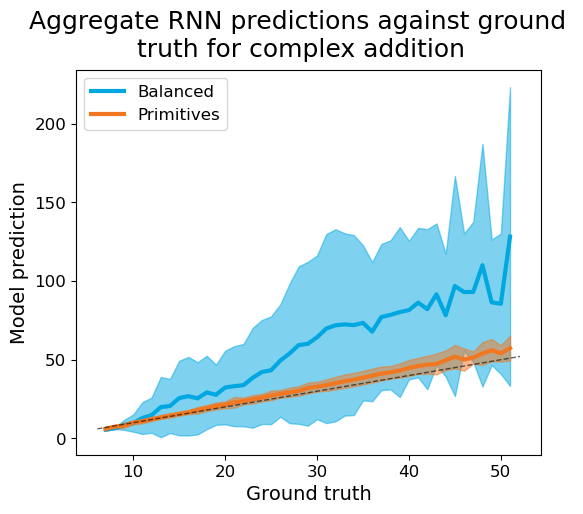

In [112]:
all_dfs_b = pd.concat(r2res_b2['ind_dfs'])
all_dfs_p = pd.concat(r2res_p2['ind_dfs'])

labels = ['Balanced', 'Primitives']
plt.rcParams['figure.figsize'] = (6,5)

for i, all_dfs in enumerate([all_dfs_b, all_dfs_p]):
    
    agg_df = all_dfs.groupby(['label']).agg({'pred': ['mean', 'std']})
    yvals = agg_df['pred']['mean']
    yerr = agg_df['pred']['std']
    xvals = agg_df.index
    plt.plot(xvals,yvals, color = bp_colors[i], linewidth=3,label=labels[i])
    plt.fill_between(xvals, yvals - yerr, yvals+yerr, color = bp_colors[i], alpha=0.5)
    xy = np.arange(np.min(yvals),53)
    
plt.plot(xy, xy, color='black', linestyle='dashed',linewidth=1, alpha=0.6)
plt.xlabel('Ground truth')
plt.ylabel('Model prediction')
plt.legend(loc = 'upper left')
plt.suptitle('Aggregate RNN predictions against ground \ntruth for complex addition', y=1)

In [135]:
r2_b = r2res_b2['ind_r2s']
r2_p = r2res_p2['ind_r2s']
N = len(r2_b)

r2_scores = r2_b + r2_p
regimes = ['Balanced']*N + ['Primitives']*N
r2_df = {'R squared score': r2_scores, 'Regime': regimes}

x_jitter = np.zeros(N) + np.random.normal(0, 0.1, N)

NameError: name 'r2res_b2' is not defined

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  wilcox
Balanced v.s. Primitives: Wilcoxon test (paired samples) with Bonferroni correction, P_val=6.807e-41 stat=7.265e+04


(<AxesSubplot: ylabel='$R^2$'>,
 [<statannot.StatResult.StatResult at 0x7f81a0cf0310>])

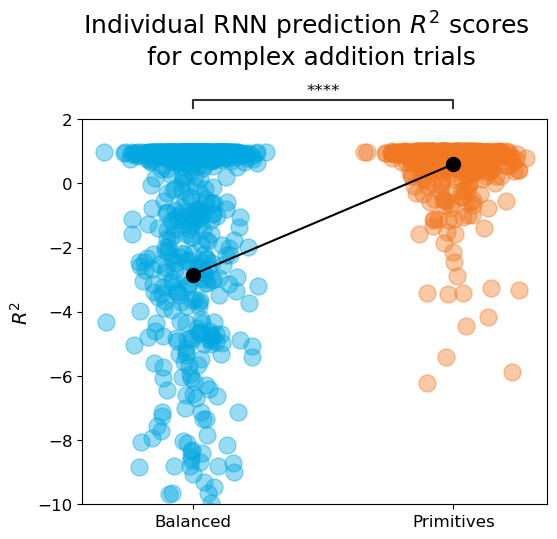

In [115]:
fig, ax = plt.subplots()
ax.scatter(x_jitter, r2_b, color = bp_colors[0], s=150,  alpha=0.4)
ax.scatter(x_jitter+1, r2_p, color = bp_colors[1], s=150,  alpha=0.4)
ax.plot([0,1], [np.mean(r2_b), np.mean(r2_p)], marker='o', color='black', markersize=10)
ax.set_xticks([0,1])
ax.set_xticklabels(['Balanced','Primitives'])
ax.set_ylim(-10,2)
ax.set_ylabel('$R^2$')
plt.suptitle('Individual RNN prediction $R^2$ scores \n for complex addition trials', y=1.1)

statannot.add_stat_annotation(
    ax,
    data=r2_df,
    x='Regime',
    y='R squared score',
    box_pairs=[('Balanced', 'Primitives')],
    test="Wilcoxon",
    text_format="star",
    loc="outside",
)


# Lazy regime

In [141]:
save_dir = '../results/train_2seqs/res_20_lazy'
with open(save_dir, 'rb') as f:
    res_lazy = pickle.load(f)

In [148]:
# extract results - lazy
tests = res_lazy['tests']
cue_dicts = res_lazy['cue_dicts']

mods_b_lazy = res_lazy['mods_b']
mods_p_lazy = res_lazy['mods_p']

r2res_p_lazy = get_r2_and_preds(mods_p_lazy, tests, hidden_size)
r2res_b_lazy = get_r2_and_preds(mods_b_lazy, tests, hidden_size)

r2_b_lazy = r2res_b_lazy['ind_r2s']
r2_p_lazy = r2res_p_lazy['ind_r2s']
N = len(r2_b_lazy)

r2_scores = r2_b_lazy + r2_p_lazy
curricula = ['Balanced']*N + ['Primitives']*N
r2_df_lazy = pd.DataFrame({'$R^2$': r2_scores, 'Curricula': curricula, 'Regime': ['Lazy']*2*N })


In [160]:
# extract results rich

tests = res['tests']
cue_dicts = res['cue_dicts']

mods_b_rich = res['mods_b']
mods_p_rich = res['mods_p']

r2res_p_rich = get_r2_and_preds(mods_p_rich, tests, hidden_size)
r2res_b_rich = get_r2_and_preds(mods_b_rich, tests, hidden_size)

r2_b_rich = r2res_b_rich['ind_r2s']
r2_p_rich = r2res_p_rich['ind_r2s']
N = len(r2_b_rich)

r2_scores = r2_b_rich + r2_p_rich
curricula = ['Balanced']*N + ['Primitives']*N
r2_df_rich = pd.DataFrame({'$R^2$': r2_scores, 'Curricula': curricula, 'Regime': ['Rich']*2*N })


In [161]:
df_rl = pd.concat([r2_df_rich, r2_df_lazy])

Text(0.5, 1.0, 'Prediction $R^2$ scores for Rich vs Lazy regimes')

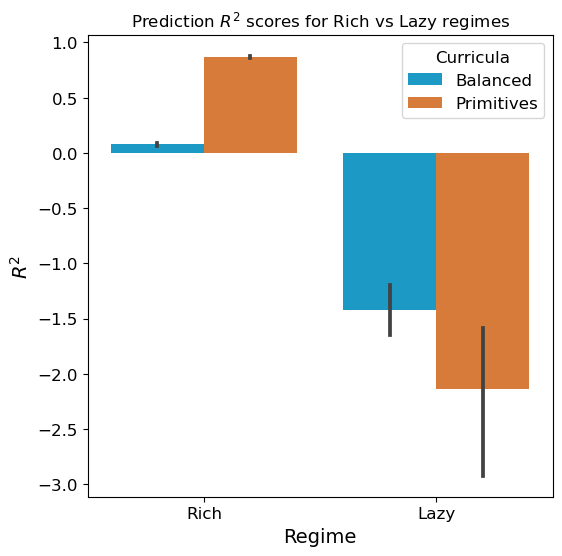

In [168]:
fig, ax = plt.subplots()
sns.barplot(data = df_rl, x = 'Regime', y='$R^2$', hue = 'Curricula', palette = bp_pal)
plt.title('Prediction $R^2$ scores for Rich vs Lazy regimes')

In [245]:
print('R2 ', round(np.mean(r2_b_lazy),3))
print('sem ', round(scipy.stats.sem(r2_b_lazy),3))

R2  -1.421
sem  0.123


In [246]:
print('R2 ', round(np.mean(r2_b_rich),3))
print('sem ', round(scipy.stats.sem(r2_b_rich),3))

R2  0.078
sem  0.007


In [247]:
print('R2 ', round(np.mean(r2_p_lazy),3))
print('sem ', round(scipy.stats.sem(r2_p_lazy),3))

R2  -2.141
sem  0.361


In [248]:
print('R2 ', round(np.mean(r2_p_rich),3))
print('sem ', round(scipy.stats.sem(r2_p_rich),3))

R2  0.867
sem  0.007


In [251]:
scipy.stats.mannwhitneyu(r2_p_lazy, r2_p_rich)

MannwhitneyuResult(statistic=698.0, pvalue=6.657534021857205e-91)

In [252]:
scipy.stats.mannwhitneyu(r2_b_lazy, r2_b_rich)

MannwhitneyuResult(statistic=10216.0, pvalue=1.9091807131375872e-64)